# AAut lab question 1 part 1
### Linear regression with outliers

 Import libraries

# Initial steps
Load libraries, load data, visual representations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, RANSACRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Load training data

In [2]:
# Importing the datasets
dataX = np.load('X_train.npy')
dataY = np.load('Y_train.npy')
testX = np.load('X_test.npy')
parameters = np.array(["air temperature", "water temperature", "wind speed", "wind direction", "illumination"])

# Important functions

Calculate SSE

In [3]:
def calculate_SSE(MSE, N):
  # Calculate the sum of squared errors
  SSE = MSE * N 
  return SSE

## Removal of outliers

#### Predict a linear regression and remove the point with the highest mse
Comment Break and uncomment remove_outliers_x_axis to also remove outliers from x

In [17]:
def remove_outliers(X, Y):
    num_points_to_remove = int(0.25 * len(Y))  # Remove 25% of the data because of human error
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    
    for _ in range(num_points_to_remove):
        model = LinearRegression()
        cv_results = cross_validate(model, X, Y, cv=5, scoring=mse_scorer, return_estimator=True)
        
        # Get the model with the lowest MSE
        best_model_index = np.argmax(cv_results['test_score'])
        best_model = cv_results['estimator'][best_model_index]
        
        predictions = best_model.predict(X)
        mse = (Y - predictions) ** 2
        
        # Remove the point with the highest MSE
        max_mse_index = np.argmax(mse)
        if mse[max_mse_index] < 1:
            # break
            pass
        
        X = np.delete(X, max_mse_index, axis=0)
        Y = np.delete(Y, max_mse_index, axis=0)
    
    return X, Y

Validation of the model with cross validation

In [5]:
def validate_model(model, X, Y):
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    r2_scorer = make_scorer(r2_score)
    cv_results = cross_validate(model, X, Y, cv=5, scoring={'mse': mse_scorer, 'r2': r2_scorer}, return_estimator=True, return_train_score=True)
    train_mse = -cv_results['train_mse'].mean()
    test_mse = -cv_results['test_mse'].mean()
    train_r2 = cv_results['train_r2'].mean()
    test_r2 = cv_results['test_r2'].mean()
    return train_mse, test_mse, train_r2, test_r2

# Experiment the models

## Remove outliers from y and x axis

In [18]:
dataX_no_outliers, dataY_no_outliers = remove_outliers(dataX, dataY)
print("Number of data points after removing outliers:", len(dataY_no_outliers))

Number of data points after removing outliers: 150


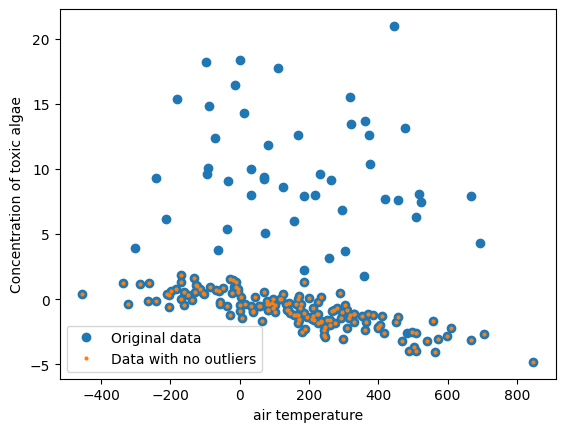

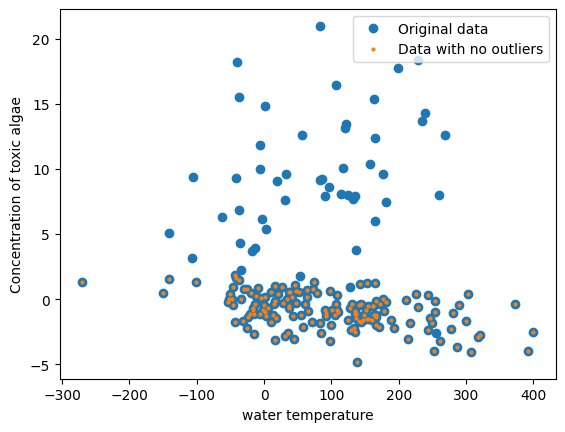

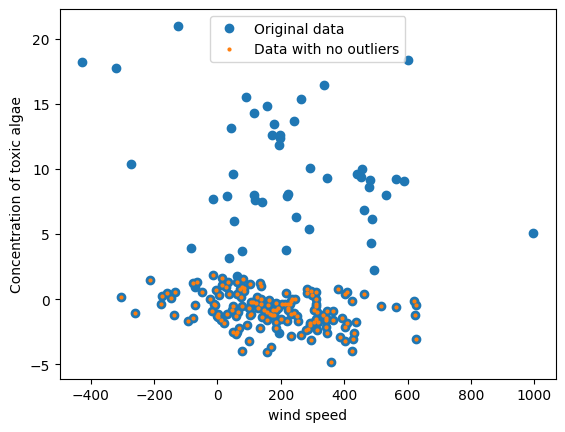

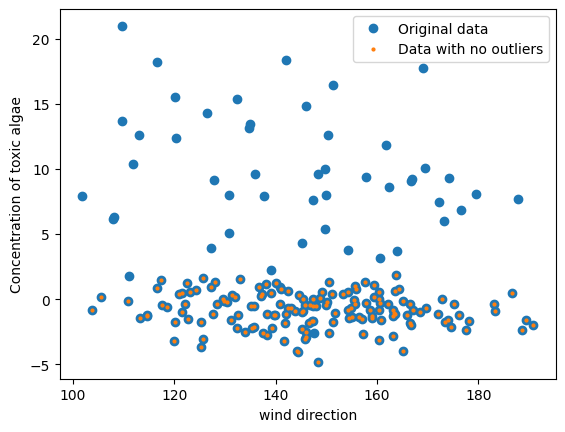

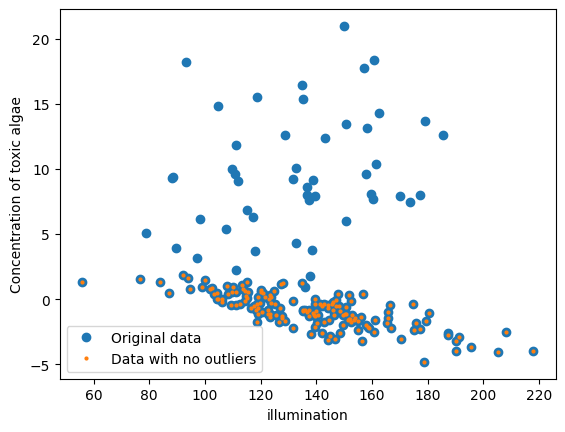

In [19]:
for i in range(dataX_no_outliers.shape[1]):
    plot = plt.figure(i)
    plt.plot(dataX[:,i], dataY, 'o')
    plt.plot(dataX_no_outliers[:,i], dataY_no_outliers, 'o', markersize=2)
    plt.xlabel(parameters[i])
    plt.ylabel("Concentration of toxic algae")
    plt.legend(["Original data", "Data with no outliers"])

### Create models

Test to see the best model

In [21]:
train_mse_LR, test_mse_LR, train_r2_LR, test_r2_LR = validate_model(LinearRegression(), dataX, dataY)

train_mse_L, test_mse_L, train_r2_L, test_r2_L = validate_model(LassoCV(max_iter=10000), dataX, dataY)

train_mse_R, test_mse_R, train_r2_R, test_r2_R = validate_model(RidgeCV(), dataX, dataY)

train_mse_RR, test_mse_RR, train_r2_RR, test_r2_RR = validate_model(RANSACRegressor(), dataX, dataY)

# Combine all MSE and R2 results
results = {
    'LinearRegression': (train_mse_LR, test_mse_LR, train_r2_LR, test_r2_LR),
    'LassoCV': (train_mse_L, test_mse_L, train_r2_L, test_r2_L),
    'RidgeCV': (train_mse_R, test_mse_R, train_r2_R, test_r2_R),
    'RANSACRegressor': (train_mse_RR, test_mse_RR, train_r2_RR, test_r2_RR)
}

print("Model\t\t\tTrain MSE\tTrain SSE\tTest MSE\tTest SSE\tTrain R2\tTest R2")
for model, (train_mse, test_mse, train_r2, test_r2) in results.items():
    train_sse = calculate_SSE(train_mse, len(dataY_no_outliers))
    test_sse = calculate_SSE(test_mse, len(dataY_no_outliers))
    print(f"{model}\t{train_mse:.6f}\t{train_sse:.6f}\t{test_mse:.6f}\t{test_sse:.6f}\t{train_r2:.6f}\t{test_r2:.6f}")

Model			Train MSE	Train SSE	Test MSE	Test SSE	Train R2	Test R2
LinearRegression	24.824616	3723.692454	26.791333	4018.699961	0.066821	-0.031867
LassoCV	25.592493	3838.873956	27.609346	4141.401922	0.038042	-0.059318
RidgeCV	24.824986	3723.747916	26.785183	4017.777508	0.066808	-0.031505
RANSACRegressor	32.408433	4861.265014	32.421103	4863.165512	-0.216971	-0.214337


In [48]:
model_LinearRegression = LinearRegression()
model_Lasso = LassoCV(max_iter=10000)
model_Ridge = RidgeCV()
model_RANSACRegressor = RANSACRegressor()

In [49]:
model_LinearRegression.fit(dataX_no_outliers, dataY_no_outliers)
model_Lasso.fit(dataX_no_outliers, dataY_no_outliers)
model_Ridge.fit(dataX_no_outliers, dataY_no_outliers)
model_RANSACRegressor.fit(dataX, dataY)

RANSACRegressor()

In [50]:
predY_LinearRegression = model_LinearRegression.predict(testX)
predY_Lasso = model_Lasso.predict(testX)
predY_Ridge = model_Ridge.predict(testX)
predY_RANSACRegressor = model_RANSACRegressor.predict(testX)

In [51]:
np.save('results_P1_1.npy', predY_Lasso)

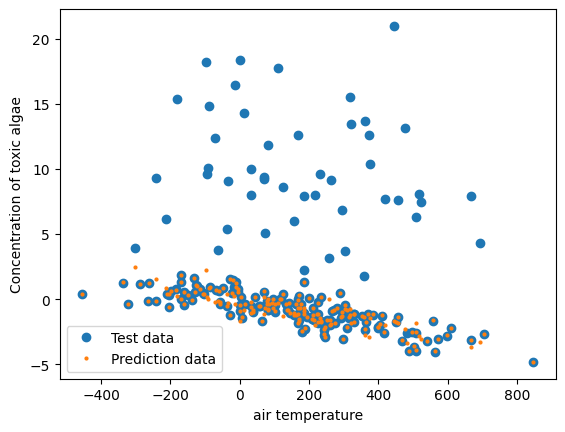

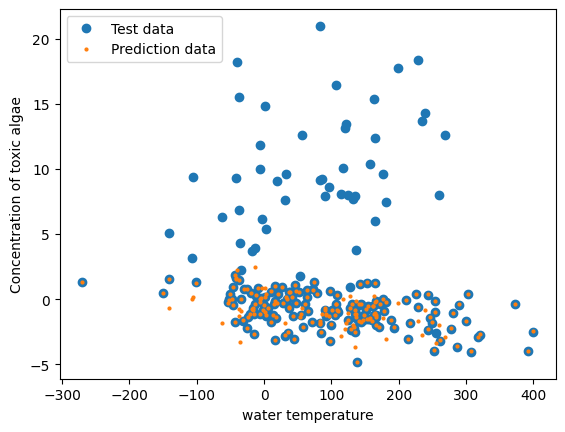

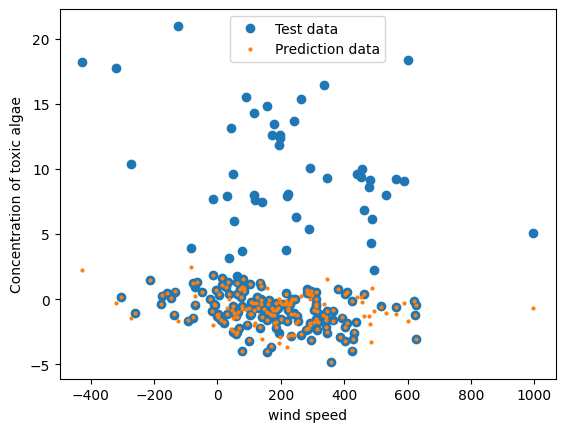

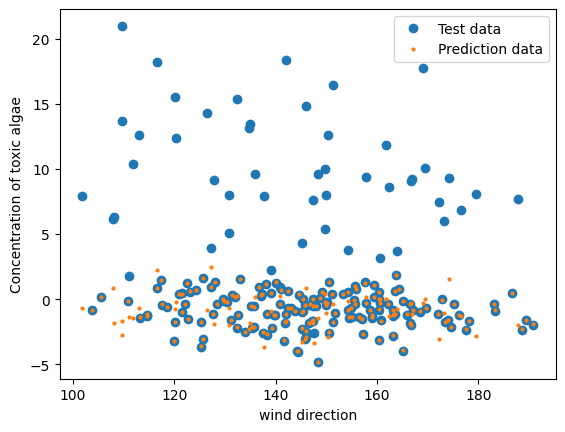

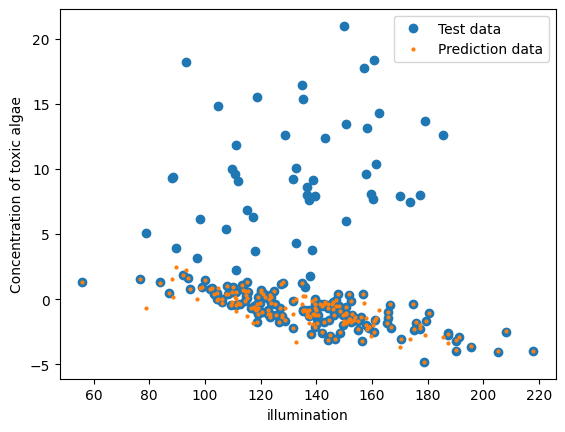

In [52]:
for i in range(dataX_no_outliers.shape[1]):
    plot = plt.figure(i)
    plt.plot(dataX[:,i], dataY, 'o')
    plt.plot(testX[:,i], predY_Lasso, 'o', markersize=2)
    plt.xlabel(parameters[i])
    plt.ylabel("Concentration of toxic algae")
    plt.legend(["Test data", "Prediction data"])